**Tabla de contenido**

- [Examinando la arquitectura ARLSTM](#Examinando-la-arquitectura-ARLSTM)
- [Construyendo un modelo LSTM autoregresivo](#Construyendo-un-modelo-LSTM-autoregresivo)
- [Próximos pasos](#Proximos-pasos)

En el último capítulo, examinamos y construimos una red neuronal convolucional (CNN). Incluso la combinamos con la arquitectura LSTM para probar si podíamos superar a los modelos LSTM. Los resultados fueron mixtos, ya que los modelos CNN tuvieron un peor rendimiento como modelos de un solo paso, el mejor rendimiento como modelos de múltiples pasos y un rendimiento igualmente bueno como modelos de múltiples salidas.

Ahora nos centraremos completamente en los modelos de múltiples pasos, ya que todos ellos generan toda la secuencia de predicciones de una sola vez. Vamos a modificar ese comportamiento y a generar gradualmente la secuencia de predicciones, utilizando predicciones pasadas para hacer nuevas predicciones. De esa manera, el modelo creará pronósticos en tiempo real, pero utilizando sus propias predicciones para informar la salida.

Esta arquitectura se utiliza comúnmente con LSTM y se llama LSTM autorregresivo (ARLSTM). En este capítulo, primero exploraremos la arquitectura general del modelo ARLSTM y luego lo construiremos en Keras para ver si podemos construir un nuevo modelo de múltiples pasos de alto rendimiento.

# Examinando la arquitectura ARLSTM

Hemos construido muchos modelos de múltiples pasos que todos generan predicciones para el volumen de tráfico en las próximas 24 horas. Cada modelo ha generado toda la secuencia de predicción de una sola vez, lo que significa que obtenemos 24 valores del modelo de inmediato.

A efectos de ilustración, consideremos un modelo simple con solo una capa LSTM. La figura 17.1 muestra la arquitectura general de los modelos de múltiples pasos que hemos construido hasta ahora. Cada uno de ellos tenía entradas que llegaban, pasando a través de una capa, ya sea LSTM, Densa o Conv1D, y resultando en una secuencia de 24 valores. Este tipo de arquitectura obliga a una salida de 24 valores.

![Arquitectura](fig/arMultiStep.png)

La Figura 17.1 ilustra un modelo multistep de disparo único con una capa LSTM. Todos los modelos multistep que hemos construido han tenido esta arquitectura general. La capa LSTM puede ser reemplazada fácilmente por una capa CNN o una capa densa.

¿Pero qué pasa si queremos una secuencia más larga? ¿O una secuencia más corta? ¿Qué pasa si deseamos predecir solo las próximas 8 horas, o predecir las próximas 48 horas? En ese caso, debemos rehacer nuestras ventanas de datos y volver a entrenar los modelos, lo cual podría representar bastante trabajo.

En cambio, podemos optar por un modelo de aprendizaje profundo autorregresivo. Como puede ver en la figura 17.2, cada predicción se envía de vuelta al modelo, lo que le permite generar la siguiente predicción. Este proceso se repite hasta obtener una secuencia de la longitud deseada.

![ARLSTM](fig/ARLSTM.png)

Figura 17.2 *Un modelo LSTM autorregresivo. Este modelo devuelve una primera predicción en t24, y se envía de vuelta al modelo para generar la predicción en t25. Este proceso se repite hasta obtener la longitud de salida deseada. Nuevamente, se muestra una capa LSTM, pero podría ser una CNN o una capa densa.*

Puede ver lo fácil que resulta generar cualquier longitud de secuencia utilizando una arquitectura de aprendizaje profundo autorregresiva. Este enfoque tiene la ventaja añadida de permitirnos pronosticar series temporales con diferentes escalas, como horas, días o meses, evitando al mismo tiempo tener que volver a entrenar a un nuevo modelo. Este es el tipo de arquitectura construida por Google DeepMind para crear WaveNet (https://deepmind.com/blog/article/wavenet-generative-model-raw-audio), un modelo que genera secuencias de audio sin procesar. En el contexto de las series temporales, DeepAR (http://mng.bz/GEoV) es una metodología que también utiliza una red neuronal recurrente autorregresiva para lograr resultados de última generación.

`Sin embargo, los modelos autorregresivos de aprendizaje profundo vienen con una advertencia importante, que es la acumulación de errores`. Hemos pronosticado muchas series temporales y sabemos que siempre hay alguna discrepancia entre nuestras predicciones y los valores reales. Ese error se acumula a medida que se retroalimenta al modelo, lo que significa que las predicciones posteriores tendrán un error mayor que las predicciones anteriores. `Por lo tanto, aunque la arquitectura autorregresiva de aprendizaje profundo parece poderosa, puede que no sea la mejor solución para un problema en particular. De ahí la importancia de utilizar un protocolo de pruebas riguroso, que es realmente lo que hemos desarrollado desde el capítulo 13.`

Aún así, es bueno tener este modelo en su caja de herramientas de métodos de pronóstico de series temporales. En la siguiente sección, codificaremos un modelo LSTM autorregresivo para producir pronósticos para las próximas 24 horas. Compararemos su rendimiento con el de nuestros modelos anteriores de varios pasos.


# Construyendo un modelo LSTM autoregresivo

Ahora estamos listos para codificar nuestro propio modelo de aprendizaje profundo autorregresivo en Keras. Específicamente, codificaremos un modelo ARLSTM, ya que nuestros experimentos han demostrado que el modelo LSTM alcanza el mejor rendimiento de los modelos de múltiples pasos. Por lo tanto, intentaremos mejorar aún más este modelo haciéndolo autorregresivo.

In [1]:
import pandas as pd
import os

file_path = lambda file: os.path.join(os.getcwd(),'data',file)
train_df = pd.read_csv(file_path('train.csv'),index_col=0)
val_df = pd.read_csv(file_path('val.csv'),index_col=0)
test_df = pd.read_csv(file_path('test.csv'),index_col=0)

train_df.head()

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,0.760019,0.0,0.758755,0.25000,0.933013
1,0.738174,0.0,0.560765,0.37059,0.982963
2,0.698884,0.0,0.463513,0.50000,1.000000
3,0.668238,0.0,0.370029,0.62941,0.982963
4,0.643093,0.0,0.325101,0.75000,0.933013


`Clase datawindow`

La clase se basa en el ancho de la entrada (input_width), el ancho de la etiqueta (label_width) y el desplazamiento (shift). El ancho de la entrada es simplemente el número de pasos de tiempo que se introducen en el modelo para hacer predicciones.

El ancho de la etiqueta (label_width) es equivalente al número de pasos de tiempo en las predicciones. 

Finalmente, el desplazamiento (shift) es el número de pasos de tiempo que separan la entrada de las predicciones. 

1. Nombre de la columna que deseamos predecir
2. Cree un diccionario con el nombre y el índice de la columna etiqueta. Esto se usará para trazar.
3. Cree un diccionario con el nombre y el índice de cada columna. Esto se usará para separar las entidades de la variable de destino.
4. La función de división devuelve un objeto de división que especifica cómo dividir una secuencia. En este caso, dice
que el segmento de entrada comienza en 0 y termina cuando alcanzamos el input_width.
5. Asigne índices a las entradas. Estos son útiles para trazar.
6. Obtenga el índice en el que comienza la etiqueta. En este caso, es el tamaño total de la ventana menos el ancho de la etiqueta.
7. Los mismos pasos que se aplicaron para las entradas se aplican para las etiquetas.
8. Corta la ventana para obtener las entradas usando el input_slice definido en __init__.
9. Corta la ventana para obtener las etiquetas usando labels_slice definido en __init__.
10. Si tenemos más de un objetivo, apilamos las etiquetas.
11. La forma será [lote, tiempo, características]. En este punto, solo especificamos la dimensión de tiempo y permitimos que las dimensiones de lote y características se definan más tarde.
12. Plotea las entradas. Aparecerán como una línea continua azul con puntos.
13. Grafique las etiquetas o los valores reales. Aparecerán como cuadrados verdes.
14. Traza las predicciones. Aparecerán como cruces rojas.

`Función que crea los tensores`


15. Pase los datos. Esto corresponde a nuestro conjunto de entrenamiento, conjunto de validación o conjunto de prueba.
16. Los objetivos se establecen en Ninguno, ya que son manejados por la función split_to_input_labels.
17. Define la longitud total del arreglo, que es igual a la longitud total de la ventana.
18. Define el número de pasos de tiempo que separan cada secuencia. En nuestro caso, queremos que las secuencias sean consecutivas, así que sequence_stride=1.
19. Baraja las secuencias. Ten en cuenta que los datos aún están en orden cronológico. Simplemente estamos cambiando el orden de las secuencias, lo que hace que el modelo sea más robusto.
20. Defina el número de secuencias en un solo lote. Recuerda que estamos reorganizando las secuencias en un lote. Esto significa que dentro de cada secuencia, los datos están en orden cronológico. Sin embargo, en un lote de 32 secuencias, podemos y debemos barajarlas para hacer que nuestro modelo sea más robusto y menos propenso al sobreajuste.

21. Obtenga un lote de muestra de datos para fines de representación gráfica. Si el lote de muestra no existe, recuperaremos un lote de muestra y lo almacenaremos en caché.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, 
                 test_df=test_df,label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns #1
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)} #2
        
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} #3

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) #4

        self.input_indices = np.arange(self.total_window_size)[self.input_slice] #5 
        self.label_start = self.total_window_size - self.label_width #6

        self.labels_slice = slice(self.label_start, None) #7 
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :] # 8
        labels = features[:, self.labels_slice, :] # 9

        if self.label_columns is not None: # 10 
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )

        inputs.set_shape([None, self.input_width, None]) #11 
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    # Método para trazar una muestra de ventanas de datos
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10) # 12
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col,None)
            else:
                label_col_index = plot_col_index
            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels',c='green', s=64) # 13
            
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :,label_col_index],marker='X', 
                            edgecolors='k', label='Predictions',c='red', s=64) #14
            if n == 0:
                plt.legend()
            plt.xlabel('Time (h)')
        
    # Función que crea los tensores con los datos temporales
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,                              # 15
            targets=None,                           #16
            sequence_length=self.total_window_size, #17
            sequence_stride=1,                      #18
            shuffle=True,                           #19
            batch_size=32                           #20
        )
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    """ 
    Concluiremos nuestra clase DataWindow definiendo algunas propiedades para aplicar 
    la función make_dataset en los conjuntos de entrenamiento, validación y prueba. 
    También crearemos un lote de muestra que almacenaremos en caché dentro de la clase para fines de trazado.
    """
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    @property
    def sample_batch(self):                          #21
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

2025-07-14 17:32:01.686864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752532321.734823   33409 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752532321.748451   33409 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752532321.850723   33409 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752532321.850743   33409 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752532321.850744   33409 computation_placer.cc:177] computation placer alr

A continuación, definiremos nuestra ventana de datos. En este caso, reutilizaremos la ventana de datos que usamos para el modelo LSTM. Las secuencias de entrada y etiqueta tendrán cada una 24 pasos de tiempo. Especificaremos un desplazamiento de 24 para que el modelo produzca 24 predicciones. Nuestro objetivo sigue siendo el volumen de tráfico.

In [3]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24,label_columns=['traffic_volume'])

Ahora envolveremos nuestro modelo en una clase llamada AutoRegressive, que hereda de la clase Model en Keras. Esto nos permite acceder a las entradas y salidas. De esta manera, podremos especificar que la salida se convierta en una entrada en cada paso de predicción.

Comenzaremos definiendo la función __init__ en nuestra clase AutoRegresiva. Esta función toma tres parámetros:
- `self—` Hace referencia a la instancia de la clase AutoRregresiva.
- `units—` Representa el número de neuronas en una capa.
- `out_steps—` Representa la longitud de la secuencia de predicción.
En este caso, es 24.

Luego utilizaremos tres capas diferentes de Keras: la capa Densa, la capa RNN y la capa LSTMCell. La capa LSTMCell es una capa de nivel inferior que la capa LSTM. Nos permite acceder a información más granular, como el estado y las predicciones, que luego podemos manipular para alimentar una salida de nuevo al modelo como entrada. En cuanto a la capa RNN, se utiliza para entrenar la capa LSTMCell con los datos de entrada. Su salida se pasa luego a través de la capa Densa para generar una predicción. Esta es la función __init__ completa.

1. El número de neuronas en una capa se define por unidades, y la longitud de la secuencia de predicción se define por out_steps.
2. La capa LSTMCell es una clase de nivel inferior que nos permite acceder a información más granular, como
como estado y salidas.
3. La capa RNN envuelve la capa LSTMCell para que sea más fácil entrenar el LSTM en los datos.
4. La predicción proviene de esta densa capa.
5. Pasa las entradas a través de la capa LSTM. La salida se envía a la capa densa.
6. Obtiene una predicción de la capa densa.
7. Inicializa una lista vacía para recopilar todas las predicciones.
8. La primera predicción se obtiene a partir de la función de calentamiento (warmup).
9. Coloca la primera predicción en la lista de predicciones.
10. La predicción se convierte en una entrada para la siguiente.
11. Genera una nueva predicción utilizando la anterior como entrada.
12. Apila todas las predicciones. En este punto, tenemos una forma (tiempo, lote, características). Debe cambiarse a (lote, tiempo, características).
13. Use transponer para obtener la forma necesaria de (lote, tiempo, características).







In [6]:
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell
from tensorflow.keras import Model, Sequential

class AutoRegressive(Model):
    def __init__(self, units, out_steps):#1
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units) #2
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True) #3
        self.dense = Dense(train_df.shape[1]) #4
    
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs) #5
        prediction = self.dense(x) #6
        return prediction, state
    """
    Ahora que tenemos una forma de capturar la primera predicción, 
    podemos definir la función llamada call, que ejecutará un bucle 
    para generar la secuencia de predicciones con una longitud de out_steps. 
    Ten en cuenta que la función debe llamarse call porque es invocada implícitamente por Keras; 
    nombrarla de otra manera resultaría en un error.

    Dado que estamos usando la clase LSTMCell, que es una clase de bajo nivel, 
    debemos pasar manualmente el estado anterior. Una vez finalizado el ciclo, 
    apilamos nuestras predicciones y nos aseguramos de que tengan la forma de salida 
    correcta utilizando el método de transposición.
    """
    def call(self, inputs, training=None):
        predictions = [] #7
        prediction, state = self.warmup(inputs) #8
        predictions.append(prediction) #9
        for n in range(1, self.out_steps):
            x = prediction #10
            x, state = self.lstm_cell(x, states=state, training=training)

            prediction = self.dense(x) #11
            predictions.append(prediction)

        predictions = tf.stack(predictions) #12
        predictions = tf.transpose(predictions, [1, 0, 2]) #13
        return predictions


Ahora hemos definido nuestra clase AutoRregresiva, que implementa un modelo LSTM autorregresivo. Podemos usarlo y entrenar un modelo en nuestros datos. Lo inicializaremos con 32 unidades y una longitud de secuencia de salida de 24 pasos de tiempo, ya que el objetivo del modelo de varios pasos es pronosticar el siguiente 24 horas.

In [7]:
# Función para configurar un modelo de aprendizaje profundo y ajustarlo a los datos
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

def compile_and_fit(model, window, patience=3, max_epochs=50): #1
    early_stopping = EarlyStopping(monitor='val_loss', #2
                                   patience=patience, #3
                                   mode='min')
    model.compile(loss=MeanSquaredError(), #4
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()]) #5
    
    history = model.fit(window.train, #6
                        epochs=max_epochs,#7
                        validation_data=window.val,#8
                        callbacks=[early_stopping]) #9
    return history

In [8]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)
history = compile_and_fit(AR_LSTM, multi_window)
ms_val_performance = {}
ms_performance = {}
ms_val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
ms_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

I0000 00:00:1752534393.585880   33409 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6150 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1752534398.548788   36690 service.cc:152] XLA service 0x45f4f7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752534398.548808   36690 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2025-07-14 18:06:38.630119: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752534399.495365   36690 cuda_dnn.cc:529] Loaded cuDNN version 90300


 16/383 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2564 - mean_absolute_error: 0.4262    

2025-07-14 18:06:44.481459: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 2164 bytes spill stores, 3164 bytes spill loads

I0000 00:00:1752534404.543700   36690 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0896 - mean_absolute_error: 0.2363 - val_loss: 0.0183 - val_mean_absolute_error: 0.0966
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0161 - mean_absolute_error: 0.0885 - val_loss: 0.0164 - val_mean_absolute_error: 0.0898
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0147 - mean_absolute_error: 0.0826 - val_loss: 0.0154 - val_mean_absolute_error: 0.0848
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0143 - mean_absolute_error: 0.0807 - val_loss: 0.0157 - val_mean_absolute_error: 0.0858
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0140 - mean_absolute_error: 0.0796 - val_loss: 0.0156 - val_mean_absolute_error: 0.0865
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0136 - mean_absolute_error: 0.0780 - val_loss: 0.0152 - val_mean_absolute_error: 0.0826
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0135 - mean_absolute_error: 0.0775 - val_loss: 

Podemos visualizar las predicciones de nuestro modelo frente a los valores reales utilizando el método plot de nuestra clase DataWindow.

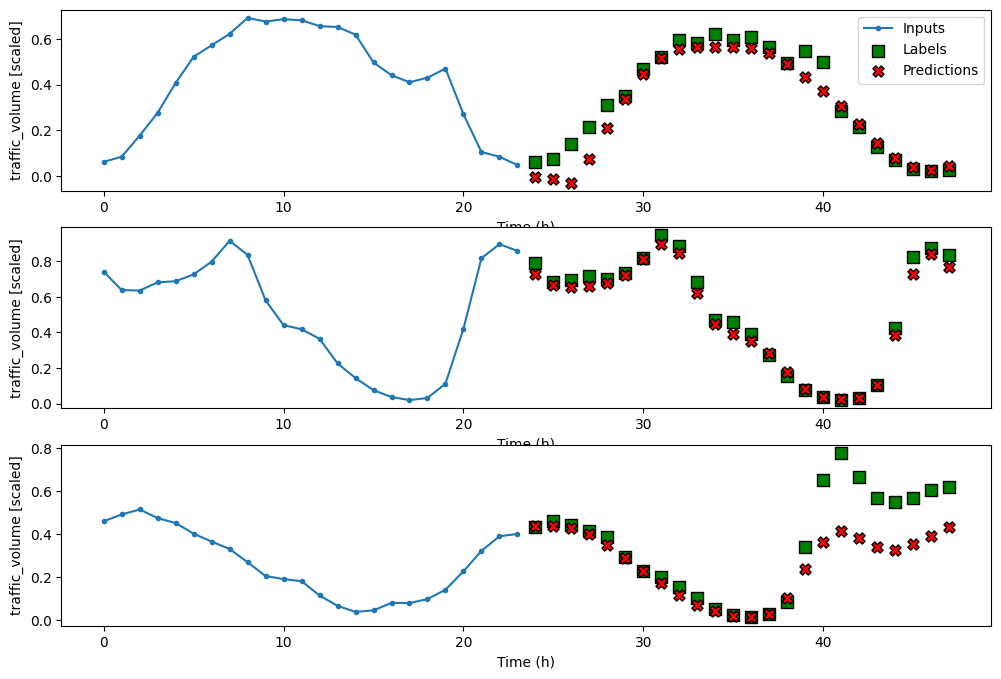

In [11]:
multi_window.plot(AR_LSTM)

Esta inspección visual no es suficiente para determinar si tenemos un nuevo modelo de alto rendimiento, por lo que mostraremos su MAE en comparación con el de todos los modelos de múltiples pasos anteriores. 

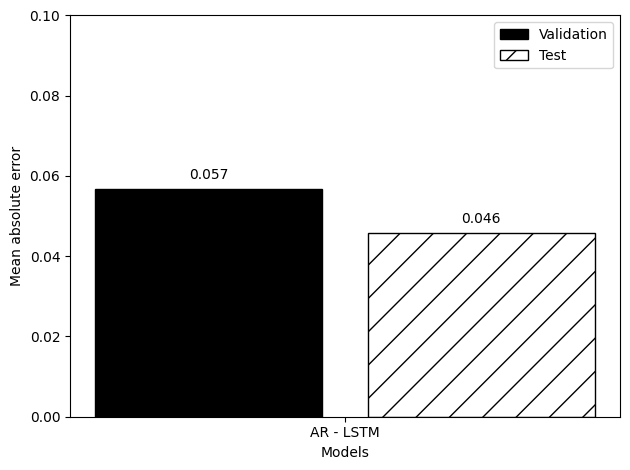

In [12]:
mae_val = [v[1] for v in ms_val_performance.values()]
mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(6)

labels = ['AR - LSTM']

x = np.arange(len(ms_performance))
fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black',label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black',hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')
for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)),ha='center')
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)),ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

El resultado que se muestra en la figura, indica que nuestro modelo LSTM autorregresivo alcanza un MAE de 0.057 en el conjunto de validación y 0.046 en el conjunto de prueba.

# Proximos pasos

Este es un capítulo bastante corto, ya que se basa en conceptos que ya hemos cubierto, como la arquitectura LSTM y la ventana de datos.

 
El modelo LSTM autorregresivo superó al modelo simple de varios pasos LSTM en nuestro ejemplo, y tuvo un mejor desempeño que un modelo CNN. Nuevamente, esto no significa que un modelo ARLSTM siempre superará a un modelo CNN o un modelo LSTM simple. Cada problema es único y una arquitectura diferente puede resultar en el mejor rendimiento para un problema diferente. Lo importante es que ahora tiene una amplia gama de modelos que puede probar y adaptar a cada problema para encontrar la mejor solución posible.

Esto lleva la parte de aprendizaje profundo del libro casi a su conclusión. En el próximo capítulo, aplicaremos nuestro conocimiento de los métodos de aprendizaje profundo para la previsión de series temporales en un proyecto final. Como antes, se proporcionará un problema y un conjunto de datos, y debemos producir un modelo de pronóstico para resolver el problema.

# Resumen

- La arquitectura autorregresiva en el aprendizaje profundo ha dado lugar a modelos de vanguardia, como WaveNet y DeepAR.
- Un modelo de aprendizaje profundo autorregresivo genera una secuencia de predicciones, pero cada predicción se retroalimenta al modelo como entrada.
- Una advertencia con respecto a los modelos autorregresivos de aprendizaje profundo es que los errores se acumulan a medida que aumenta la longitud de la secuencia. Por lo tanto, una mala predicción temprana puede tener un gran efecto en una predicción tardía.
